In [1]:
import numpy as np
import time
from functools import partial

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
plt.style.use('ggplot')

In [2]:
DAYS = 100
SEATS = 100

DEMAND_MIN = 100
DEMAND_MAX = 200

In [3]:
def cumulative_revenue( days_left,
                      tickets_left,
                      pricing_function,
                      rev_to_date=0,
                      demand_min=DEMAND_MIN,
                      demand_max=DEMAND_MAX):
    """" 
    helper function to calculate revenue for a given pricing function
    """
    
    if days_left>0 and tickets_left>0:
        demand = np.random.randint(demand_min,demand_max+1)
        p = pricing_function(days_left,tickets_left,demand)
        q = demand - p             # quantity of tickets sold on current day
        q = max(0,q)               # cannot sell less than 0 tickets
        q=min(tickets_left,q)      # cannot sell more than the tickets left
        
        return cumulative_revenue(days_left=days_left-1,
                                 tickets_left=tickets_left-q,
                                 pricing_function=pricing_function,
                                 rev_to_date=rev_to_date + p*q)
    
    else:
        return rev_to_date
        

In [4]:
# Creating a linear pricing function
def pf_linear(days_left,tickets_left,demand_level):
    
    price = demand_level - int(tickets_left/days_left)
    return max(0,price)


In [5]:
revenue = cumulative_revenue(DAYS,SEATS,pf_linear)
print(f'Revenue: {revenue:,}      Average Price per ticket: {revenue/SEATS:.1f}')

Revenue: 14,839      Average Price per ticket: 148.4


Text(0.5, 1.0, 'Revenue mean: 14,903  std: 290')

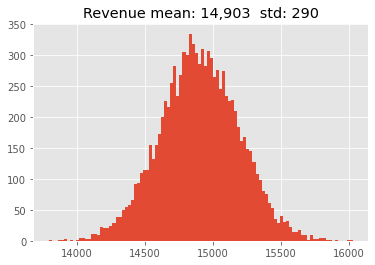

In [6]:
sim = [cumulative_revenue(DAYS,SEATS,pf_linear) for i in range(10000)]
plt.hist(sim,bins=100)
plt.title(f'Revenue mean: {np.mean(sim):,.0f}  std: {np.std(sim):,.0f}')

In [7]:
print(np.max(sim))

16030


In [8]:
# Creating an adaptive pricing function based on demand level
def pf_adaptive(days_left,tickets_left,demand_level,adapt=1):
    
    price = demand_level - int((1 + adapt*(demand_level/150))*tickets_left/days_left)
    return max(0, price)

revenue = cumulative_revenue(DAYS,SEATS,pf_adaptive)
print(f'Revenue: {revenue:,}      Average Price per ticket: {revenue/SEATS:.1f}')

Revenue: 15,796      Average Price per ticket: 158.0


Text(0.5, 1.0, 'Revenue mean: 15,360  std: 301')

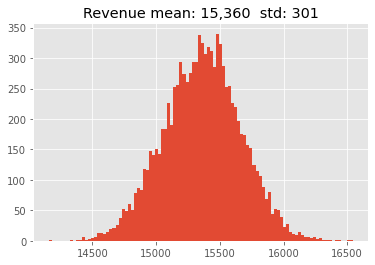

In [9]:
sim = [cumulative_revenue(DAYS,SEATS,pf_adaptive) for i in range(10000)]
plt.hist(sim,bins=100)
plt.title(f'Revenue mean: {np.mean(sim):,.0f}  std: {np.std(sim):,.0f}')

In [10]:
print(np.max(sim))

16544


Text(0.5, 1.0, 'Adaptive pricing total revenue')

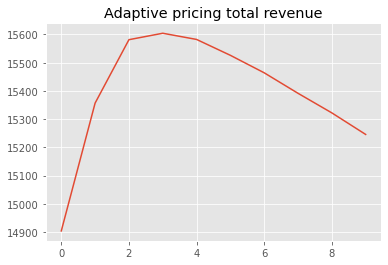

In [11]:
means = []
for w in range(10):
    sim = [cumulative_revenue(DAYS,SEATS,partial(pf_adaptive, adapt=w)) for i in range(10000)]
    means.append(np.mean(sim))
    
plt.plot(means)
plt.title('Adaptive pricing total revenue')

In [12]:
## Pricing using dynamic programming

## For the last day before flight
days_range = list(range(DAYS))
seats_range = list(range(SEATS+1))
demand_range = list(range(DEMAND_MIN,DEMAND_MAX+1))

In [13]:
r_max = np.zeros((len(seats_range),len(demand_range)))
for seats in seats_range:
    for demand in demand_range:
        r_max[seats,demand-DEMAND_MIN] = 0
        for p in range (demand-seats, demand+1):
            q = demand - p
            r = p*q
            if r>r_max[seats,demand-DEMAND_MIN]:
                r_max[seats,demand-DEMAND_MIN] = r


C:\Users\ishaa\AppData\Local\Temp\ipykernel_4712\3833706443.py:3: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


Text(0.5, 0.5, 'seats left')

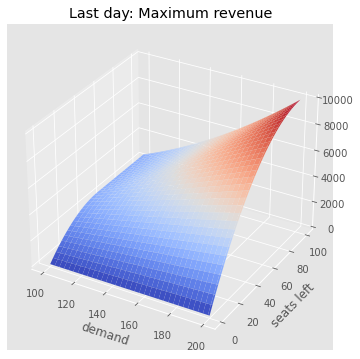

In [14]:
x, y, z = demand_range, seats_range, r_max
fig = plt.figure(figsize=(8,6))
ax = fig.gca(projection='3d')
x, y = np.meshgrid(x,y)
surface = ax.plot_surface(x,y,z, cmap=cm.coolwarm)
plt.title('Last day: Maximum revenue')
plt.xlabel('demand'); plt.ylabel('seats left')

In [15]:
def _tickets_sold(p, demand_level, max_qty):
    #quantity_demanded = floor(max(0, p - demand_level))
    quantity_demanded = demand_level - p
    q = max(0,quantity_demanded)               # cannot sell less than 0 tickets
    q=min(max_qty,quantity_demanded)      # cannot sell more than the tickets left

    return min(quantity_demanded, max_qty)

def simulate_revenue(days_left, tickets_left, pricing_function, rev_to_date=0, demand_level_min=100, demand_level_max=200):
    if (days_left == 0) or (tickets_left == 0):
        return rev_to_date
    else:
        demand_level = np.random.randint(demand_level_min, demand_level_max)
        p = pricing_function(days_left, tickets_left, demand_level)
        q = _tickets_sold(p, demand_level, tickets_left)

        print(f'Tickets left: {tickets_left:,}    Price: {p:,}    Demand: {demand_level:,}     Sold: {q:,}')

        return simulate_revenue(days_left = days_left, 
                              tickets_left = tickets_left-q, 
                              pricing_function = pricing_function, 
                              rev_to_date = rev_to_date + p * q
                             )

In [16]:
price = np.zeros((101, 101, 201), dtype='uint8') # The optimal price given the number of days left, tickets left and current demand level
profit = np.zeros((101, 101)) # Expected profit when pricing optimally given the number of days and tickets left
    
# Base case when there is 1 day left
for tickets in range(101):
    for demand in range(100, 200):
        q = min(demand // 2, tickets) # This is the optimal quantity to sell
        p = demand - q

        price[1, tickets, demand] = p
        profit[1, tickets] += (p*q / 100) # Average out the best profit through all possible demand levels (to get the expected profit)

# Fill in the tables
for day in range(2, 101):
    for tickets in range(101):
        for demand in range(100, 200):

            best_prof = 0
            best_price = 0

            for p in range(1, demand+1): # Go though all feasible prices
                q = min(demand-p, tickets) # This is the quantity that will be sold at price p

                prof = p*q + profit[day-1, tickets-q] # This is the total expected profit if selling at price p

                if prof > best_prof: # Update best profit and price
                    best_prof = prof
                    best_price = p

            # Set the optimal price and profit values
            price[day, tickets, demand] = best_price
            profit[day, tickets] += (best_prof / 100) # Average out the best profit through all possible demand levels  

    print(f'Day: {day:,}    Revenue: {best_prof:,}      Average Price per ticket: {best_price:,}')

Day: 2    Revenue: 12,731.0      Average Price per ticket: 137
Day: 3    Revenue: 13,779.0      Average Price per ticket: 149
Day: 4    Revenue: 14,389.376      Average Price per ticket: 155
Day: 5    Revenue: 14,824.373383999999      Average Price per ticket: 159
Day: 6    Revenue: 15,161.706876720002      Average Price per ticket: 162
Day: 7    Revenue: 15,435.358699535196      Average Price per ticket: 165
Day: 8    Revenue: 15,664.119685197385      Average Price per ticket: 167
Day: 9    Revenue: 15,859.94907455498      Average Price per ticket: 168
Day: 10    Revenue: 16,029.657307270129      Average Price per ticket: 170
Day: 11    Revenue: 16,179.519352508052      Average Price per ticket: 171
Day: 12    Revenue: 16,312.79566268538      Average Price per ticket: 172
Day: 13    Revenue: 16,432.442770893682      Average Price per ticket: 173
Day: 14    Revenue: 16,540.649117912588      Average Price per ticket: 174
Day: 15    Revenue: 16,639.447759325805      Average Price per tic

In [17]:
def pricing_function(days_left, tickets_left, demand_level):
    """Return the optimal price"""
    
    # These should be cast to an integer (and rounded down)
    tickets_left = int(tickets_left)
    demand_level = int(demand_level)

    return price[days_left, tickets_left, demand_level] # Return the precomputed values

simulate_revenue(days_left=100, tickets_left=100, pricing_function=pricing_function)

In [19]:
def simulate_revenue(days_left, tickets_left, pricing_function, rev_to_date=0, demand_level_min=100, demand_level_max=200):
    if (days_left == 0) or (tickets_left == 0):
        return rev_to_date
    else:
        demand_level = np.random.randint(demand_level_min, demand_level_max)
        p = pricing_function(days_left, tickets_left, demand_level)
        q = _tickets_sold(p, demand_level, tickets_left)

        return simulate_revenue(days_left = days_left, 
                              tickets_left = tickets_left-q, 
                              pricing_function = pricing_function, 
                              rev_to_date = rev_to_date + p * q
                             )

sim = [simulate_revenue(days_left=100, tickets_left=100, pricing_function=pricing_function) for i in range(10000)]

Text(0.5, 1.0, 'Revenue mean: 18,975    std: 40')

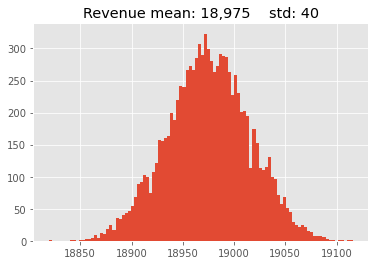

In [20]:
plt.hist(sim, bins=100)
plt.title(f'Revenue mean: {np.mean(sim):,.0f}    std: {np.std(sim):,.0f}')

In [21]:
print(np.max(sim))

19116
